# Solving different instance classes with QAOA and VQE in `qiskit`


Consider an $n$-node undirected graph $G = (V, E)$ where $|V| = n$ with edge weights $w_{ij} \geq 0$, $w_{ij} = w_{ji}$ for $(i, j) \in E$. A cut is defined as a partition of the original set $V$ into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, crossing the cut.



## Things for SPARTAN RUN

- y = Mean(Energy Gap)
- f(x) := {Set of Features from Fens thesis}
- Optimization = COBYLA
- 10 restarts
- 5 instances types
	- 30 of each type
- Algorithm:
	- VQE
        - 10 paramaters
        - 20 parameters
        - 30 parameters
    - QAOA
        - **PASS**
        - More layers >> better
- 150 runs
- Maximum # of Function Evaluations is 1000\*G.nodes() (look at n layers, 1:N)
    - Better in more or LESS layers
    
    

In [139]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import json
import networkx as nx
import random
import copy
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import seaborn as sns

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA, NELDER_MEAD

sns.set_theme()


In [8]:
import qiskit
qiskit.__version__

'0.21.2'

# Types of Instances

We are going to investigate the following types of instances:

1. **Uniform Random Graphs** -- graph edges chosen at random
2. **Power Law Trees** -- trees with power law degree distribution where the exponent is chosen to be 3
3. **Watts-Strogatz small world graphs** - graphs with high clustering coefficient, small average path length
4. **Geometric Graphs** -- graph nodes are placed uniformly at random inside the unit cube with a max distaince between the nodes of 4
5. **Nearly Complete BiPartite graphs** -- graphs that have had 1 to 3 edges added or removed from a complete bipartite graph

In [113]:
class GraphInstance:
    def __init__(self, G, graph_type):
        self.G = G
        self.graph_type = graph_type
        self.weight_matrix = None
        self.brute_force_sol = None
        
    def __repr__(self):
        return f"This is a {self.graph_type} {self.G} graph instance"
    
    def allocate_random_weights(self):
        # Allocate random costs to the edges for now
        for (u, v) in self.G.edges():
            self.G.edges[u,v]['weight'] = random.randint(0,10)
        
    
    def compute_weight_matrix(self):
        G = self.G
        n = len(G.nodes())
        w = np.zeros([n,n])
        for i in range(n):
            for j in range(n):
                temp = G.get_edge_data(i,j,default=0)
                if temp != 0:
                    w[i,j] = temp['weight']
        self.weight_matrix = w
        
    def show_weight_matrix(self):
        print(self.weight_matrix)
        
    def build_qubo():
        pass
    
    def solve_qaoa():
        pass
    
    def solve_vqe():
        pass

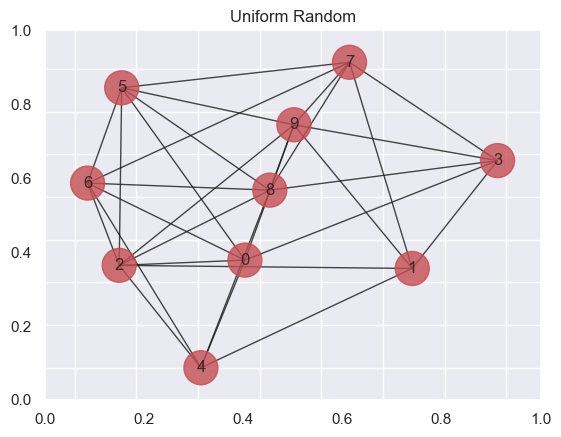

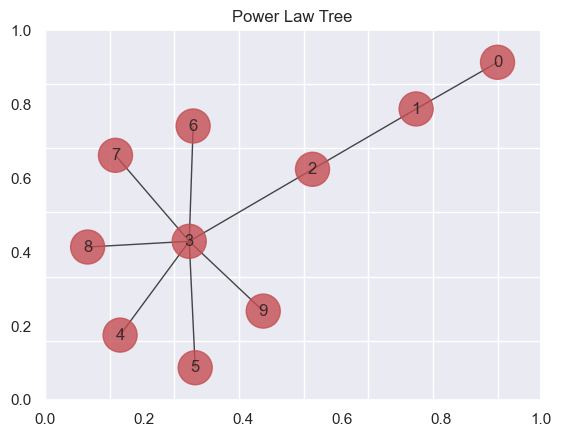

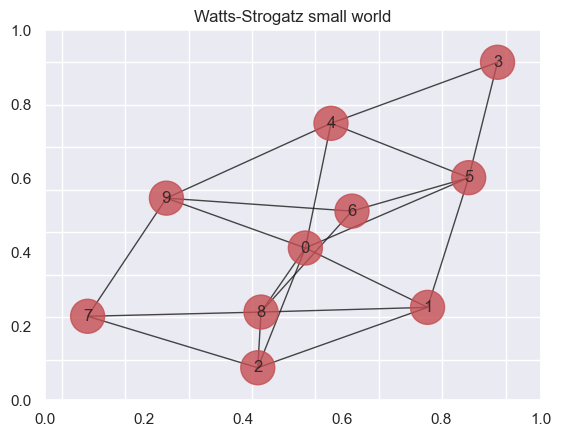

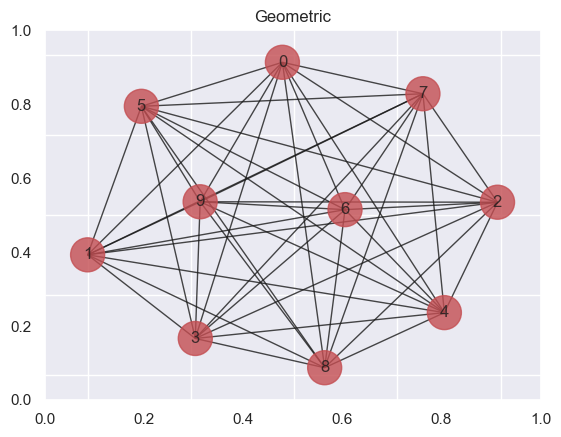

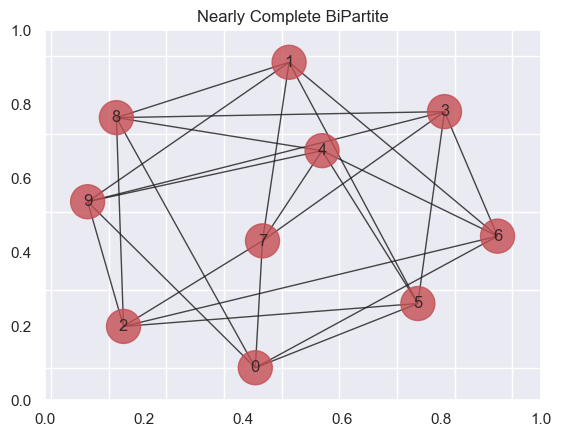

In [114]:
# Number of nodes
N = 10

# Generating a graph of 10 nodes
G_unif = GraphInstance(nx.gnm_random_graph(N, 30), "Uniform Random")
G_pl_tree = GraphInstance(nx.random_powerlaw_tree(N, gamma=3, seed=None, tries=100), "Power Law Tree")
G_wattz = GraphInstance(nx.connected_watts_strogatz_graph(N,k=4,p=0.5), "Watts-Strogatz small world")
G_geom = GraphInstance(nx.random_geometric_graph(N, radius=4), "Geometric")
G_nc_bipart = GraphInstance(nx.complete_bipartite_graph(int(N/2),int(N/2)), "Nearly Complete BiPartite")


G_instances = [G_unif, G_pl_tree, G_wattz, G_geom, G_nc_bipart]

for i, graph_instance in enumerate(G_instances):
    G = graph_instance.G

    plt.figure(i)


    # Draw the different types of graphs
    colors = ['r' for node in G.nodes()]
    pos = nx.spring_layout(G)
    ax = plt.gca()
    ax.set_title(graph_instance.graph_type)

    def draw_graph(G, colors, pos):
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    draw_graph(G, colors, pos)
plt.show()

In [120]:
# Computing the weight matrix for each Graph
for i, G in enumerate(G_instances):
    print(G)
    G.allocate_random_weights()
    G.compute_weight_matrix()
    print(G.weight_matrix)
    

This is a Uniform Random Graph with 10 nodes and 30 edges graph instance
[[ 0.  0.  4.  2.  9.  7.  8.  0.  0.  8.]
 [ 0.  0.  6.  9.  9.  0.  0.  7.  0.  6.]
 [ 4.  6.  0.  0.  4.  4.  0.  0.  2.  4.]
 [ 2.  9.  0.  0.  0.  0.  0. 10.  5.  7.]
 [ 9.  9.  4.  0.  0.  0.  9.  0.  0.  0.]
 [ 7.  0.  4.  0.  0.  0.  7.  7.  2.  0.]
 [ 8.  0.  0.  0.  9.  7.  0.  0.  1.  0.]
 [ 0.  7.  0. 10.  0.  7.  0.  0.  1.  2.]
 [ 0.  0.  2.  5.  0.  2.  1.  1.  0.  0.]
 [ 8.  6.  4.  7.  0.  0.  0.  2.  0.  0.]]
This is a Power Law Tree Graph with 10 nodes and 9 edges graph instance
[[ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.]
 [10.  0.  7.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  9.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  0. 10.  2.  2.  5.  4.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  5.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.

Solving Brute Force for Uniform Random

Best solution = [1, 1, 0, 0, 0, 0, 1, 1, 1, 0] cost = 104.0


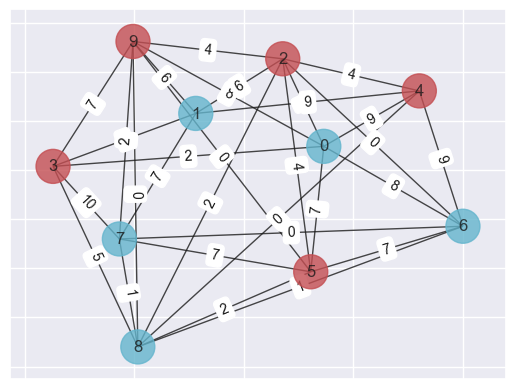

Solving Brute Force for Power Law Tree

Best solution = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 49.0


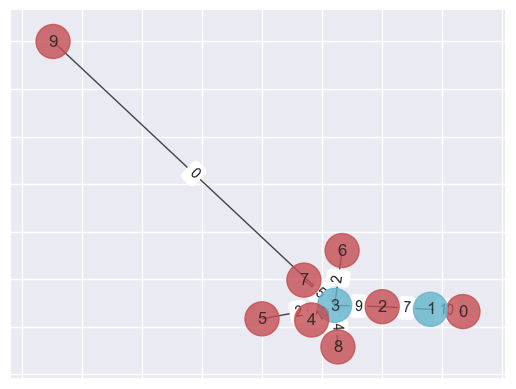

Solving Brute Force for Watts-Strogatz small world

Best solution = [1, 1, 0, 1, 1, 0, 1, 1, 0, 0] cost = 87.0


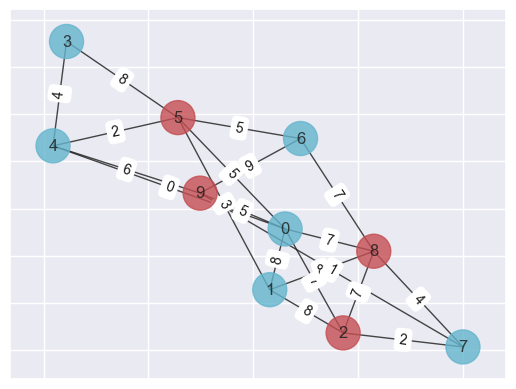

Solving Brute Force for Geometric

Best solution = [0, 0, 1, 0, 1, 1, 1, 1, 1, 0] cost = 141.0


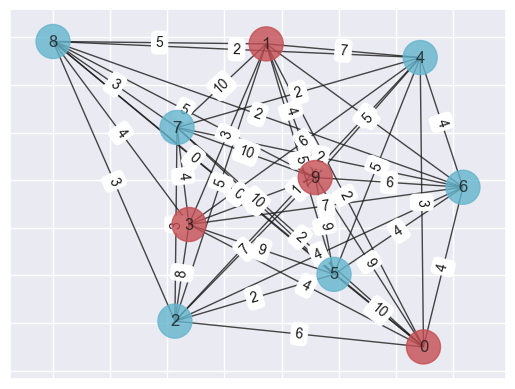

Solving Brute Force for Nearly Complete BiPartite

Best solution = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0] cost = 101.0


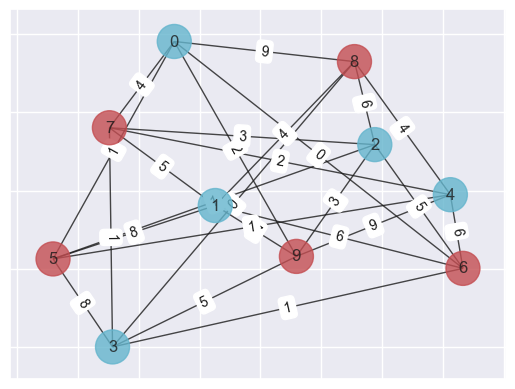

In [121]:
for i, graph_instance in enumerate(G_instances):
    print(f"Solving Brute Force for {graph_instance.graph_type}")
    G = graph_instance.G
    w = graph_instance.weight_matrix
    n = len(G.nodes())
    
    best_cost_brute = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + w[i,j]*x[i]*(1-x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
    
    colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
#    colors='red'
    pos = nx.spring_layout(G)
    print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))
    draw_graph(G, colors, pos)
    plt.show()

In [167]:
print(f"\n{'-'*50}\n Running Experiment for {graph_instance.graph_type}\n{'-'*50}\n")


max_cut = Maxcut(graph_instance.weight_matrix)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())
print('\nBest solution BRUTE FORCE = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))


# Check that the Hamiltonian gives the right cost
print(f"\n{'-'*10} Checking that current Hamiltonian gives right cost {'-'*10}\n")

ee = NumPyMinimumEigensolver()

# Calculate the min eigenvalue
optimal_result = ee.compute_minimum_eigenvalue(qubitOp)

ground_state = max_cut.sample_most_likely(optimal_result.eigenstate)
print('ground state energy:', optimal_result.eigenvalue.real)
print('optimal max-cut objective:', optimal_result.eigenvalue.real + offset)
print('ground state solution:', ground_state)
print('ground state objective:', qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
# draw_graph(G, colors, pos)


################################
# Quantum Run -- VQE
################################

print(f"\n{'-'*10} Simulating Instance on Quantum using VQE {'-'*10}\n")

# Run optimisation code
optimizers = [
    COBYLA(maxiter=100), 
#     SPSA(maxiter=5000), 
#     NELDER_MEAD(maxfev=10000)
]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
num_qubits = qubitOp.num_qubits

init_state = np.random.rand(num_qubits)*2*np.pi
print(f"The initial state is {init_state}")
n_restarts = 1
optimizer_results = []

result = {"algo": None,"result": None}


print(f"The initial state is {init_state}")

n_restarts = 3

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print(f'Testing Optimizer {i+1}: {type(optimizer).__name__}')

    counts = []
    values = []
    
    # Callback definition
    def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count % 100 == 0:
            print(f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}")
        counts.append(eval_count)
        values.append(mean)
    
    for restart in range(n_restarts):
        print(f"Running Optimization at n_restart={restart}")
        init_state = np.random.rand(4)*2*np.pi

        # Define the systems of rotation for x and y
        ry = TwoLocal(num_qubits, "ry", "cz", reps=2, entanglement="linear")
        
        # VQE definition
        vqe = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)
        algo_result = vqe.compute_minimum_eigenvalue(qubitOp)
    
    # Convergence array
    total_counts = np.arange(0, len(counts))
    converge_cnts[i] = total_counts
    converge_vals[i] = np.asarray(values)

    print(f"\n{'-'*10} Optimization Complete {'-'*10}\n")    
    
    # Sample most liklely eigenstate
    x = max_cut.sample_most_likely(algo_result.eigenstate)
    print("Final energy:", algo_result.eigenvalue.real)
    print("time:", algo_result.optimizer_time)
    print("max-cut objective:", algo_result.eigenvalue.real + offset)
    print("solution:", x)
    print("solution objective:", qp.objective.evaluate(x))
    print("energy_gap:", algo_result.eigenvalue.real/optimal_result.eigenvalue.real)
    
# pylab.rcParams['figure.figsize'] = (12, 8)
# for i in range(len(optimizers)):
#     pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizers[i]).__name__)
# pylab.xlabel('Eval count')
# pylab.ylabel('Energy')
# pylab.title('Energy convergence for various optimizers')
# pylab.legend(loc='upper right')
    


--------------------------------------------------
 Running Experiment for Nearly Complete BiPartite
--------------------------------------------------

Problem name: Max-cut

Maximize
  -2*x_0*x_5 - 8*x_0*x_7 - 18*x_0*x_8 - 4*x_0*x_9 - 16*x_1*x_5 - 12*x_1*x_6
  - 10*x_1*x_7 - 8*x_1*x_8 - 14*x_1*x_9 - 2*x_2*x_5 - 10*x_2*x_6 - 6*x_2*x_7
  - 12*x_2*x_8 - 6*x_2*x_9 - 16*x_3*x_5 - 2*x_3*x_6 - 2*x_3*x_7 - 10*x_3*x_9
  - 2*x_4*x_5 - 12*x_4*x_6 - 4*x_4*x_7 - 8*x_4*x_8 - 18*x_4*x_9 + 16*x_0
  + 30*x_1 + 18*x_2 + 15*x_3 + 22*x_4 + 19*x_5 + 18*x_6 + 15*x_7 + 23*x_8
  + 26*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Offset: -50.5
Ising Hamiltonian:
0.5 * IIIIZIIIIZ
+ 4.0 * IIIIZIIIZI
+ 0.5 * IIIIZIIZII
+ 4.0 * IIIIZIZIII
+ 0.5 * IIIIZZIIII
+ 3.0 * IIIZIIIIZI
+ 2.5 * IIIZIIIZII
+ 0.5 * IIIZIIZIII
+ 3.0 * IIIZIZIIII
+ 2.0 * IIZIIIIIIZ
+ 2.5 * IIZIIIIIZI
+ 1.5 * IIZIIIIZII
+ 0.5 * IIZIIIZIII
+ 1.0 * IIZIIZIIII
+ 4.5 * IZIIIIIIIZ
+ 2.0 * IZI